In [1]:
# DeepONet
import deepxde as dde
import deepxde.backend as B

# Backend as PyTorch
B.backend.torch

# PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Scheduler - OneCycleLR
from torch.optim.lr_scheduler import OneCycleLR

# PyTorch Lightning
import lightning as L
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor
import wandb

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
L.seed_everything(42)

Seed set to 42


42

In [3]:
df_grf = pl.read_parquet("../data/grf.parquet")
df_grf_int = pl.read_parquet("../data/grf_int.parquet")

In [4]:
print(df_grf, df_grf_int)

shape: (1_000_000, 3)
┌───────┬──────────┬───────┐
│ x     ┆ grf      ┆ group │
│ ---   ┆ ---      ┆ ---   │
│ f64   ┆ f64      ┆ u64   │
╞═══════╪══════════╪═══════╡
│ 0.0   ┆ 1.034109 ┆ 0     │
│ 0.001 ┆ 1.032658 ┆ 0     │
│ 0.002 ┆ 1.031061 ┆ 0     │
│ 0.003 ┆ 1.02932  ┆ 0     │
│ 0.004 ┆ 1.027434 ┆ 0     │
│ …     ┆ …        ┆ …     │
│ 0.996 ┆ 0.143732 ┆ 999   │
│ 0.997 ┆ 0.151847 ┆ 999   │
│ 0.998 ┆ 0.159901 ┆ 999   │
│ 0.999 ┆ 0.167892 ┆ 999   │
│ 1.0   ┆ 0.175821 ┆ 999   │
└───────┴──────────┴───────┘ shape: (100_000, 3)
┌──────┬──────────┬───────┐
│ y    ┆ grf_int  ┆ group │
│ ---  ┆ ---      ┆ ---   │
│ f64  ┆ f64      ┆ u64   │
╞══════╪══════════╪═══════╡
│ 0.0  ┆ 0.0      ┆ 0     │
│ 0.01 ┆ 0.010248 ┆ 0     │
│ 0.02 ┆ 0.020216 ┆ 0     │
│ 0.03 ┆ 0.029769 ┆ 0     │
│ 0.04 ┆ 0.038783 ┆ 0     │
│ …    ┆ …        ┆ …     │
│ 0.96 ┆ 0.066456 ┆ 999   │
│ 0.97 ┆ 0.06514  ┆ 999   │
│ 0.98 ┆ 0.064748 ┆ 999   │
│ 0.99 ┆ 0.065252 ┆ 999   │
│ 1.0  ┆ 0.066605 ┆ 999   │
└──────┴─────────

In [5]:
df_grf = df_grf.filter(pl.col("x").is_in([round(x * 0.01, 2) for x in range(101)]))
print(df_grf)

shape: (100_000, 3)
┌──────┬───────────┬───────┐
│ x    ┆ grf       ┆ group │
│ ---  ┆ ---       ┆ ---   │
│ f64  ┆ f64       ┆ u64   │
╞══════╪═══════════╪═══════╡
│ 0.0  ┆ 1.034109  ┆ 0     │
│ 0.01 ┆ 1.013118  ┆ 0     │
│ 0.02 ┆ 0.978182  ┆ 0     │
│ 0.03 ┆ 0.930308  ┆ 0     │
│ 0.04 ┆ 0.870871  ┆ 0     │
│ …    ┆ …         ┆ …     │
│ 0.96 ┆ -0.17806  ┆ 999   │
│ 0.97 ┆ -0.085153 ┆ 999   │
│ 0.98 ┆ 0.006252  ┆ 999   │
│ 0.99 ┆ 0.093782  ┆ 999   │
│ 1.0  ┆ 0.175821  ┆ 999   │
└──────┴───────────┴───────┘


In [6]:
x = df_grf.filter(pl.col("group") == 0)["x"].to_numpy()
# y = df_grf_int.filter(pl.col("group") == 0)["y"].to_numpy().reshape(-1, 1)
y = df_grf_int.group_by("group", maintain_order=True).agg(pl.col("y"))["y"].explode().to_numpy().reshape(1000, -1)
grfs = df_grf.group_by("group", maintain_order=True).agg(pl.col("grf"))["grf"].explode().to_numpy().reshape(1000, -1)
grf_ints = df_grf_int.group_by("group", maintain_order=True).agg(pl.col("grf_int"))["grf_int"].explode().to_numpy().reshape(1000, -1)

y = y.astype(np.float32)
grfs = grfs.astype(np.float32)
grf_ints = grf_ints.astype(np.float32)

print(f"x: {x.shape}, y: {y.shape}")
print(f"grfs: {grfs.shape}, grf_ints: {grf_ints.shape}")

x: (100,), y: (1000, 100)
grfs: (1000, 100), grf_ints: (1000, 100)


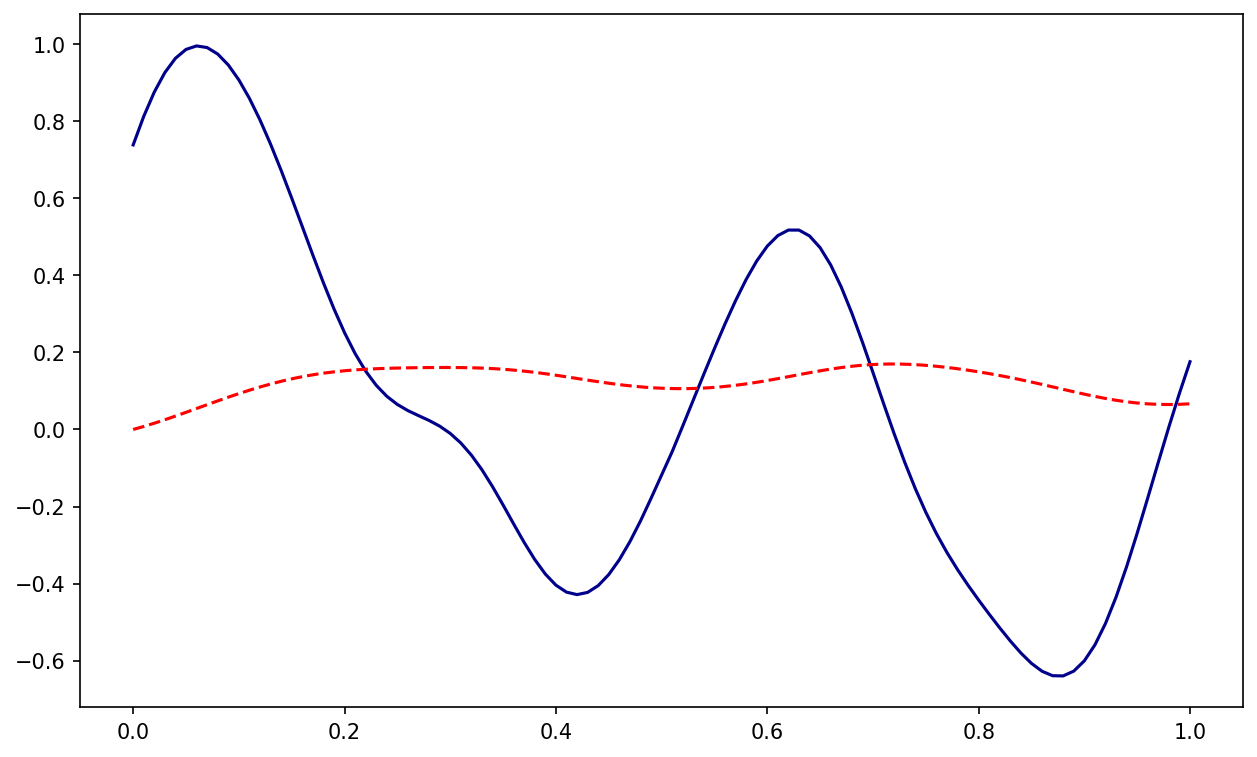

In [7]:
i = 999
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, grfs[i], '-', color='darkblue', label="GRF")
plt.plot(y[i], grf_ints[i], 'r--', label="Integral")
plt.show()

## DeepONet from Scratch

$$
G: u \in C[\mathcal{D}] \rightarrow G(u) \in C[\mathcal{R}] \quad \text{where } \mathcal{D}, \mathcal{R} \text{ are compact}
$$
$$
u(x) \overset{G}{\longrightarrow} G(u)(y) = \int_0^y u(x) dx
$$

In [8]:
n_train = 800
n_val = 100
n_test = 1000 - n_train - n_val

grf_train = grfs[:n_train]
grf_val = grfs[n_train:n_train + n_val]
grf_test = grfs[n_train + n_val:]

y_train = y[:n_train]
y_val = y[n_train:n_train + n_val]
y_test = y[n_train + n_val:]

grf_int_train = grf_ints[:n_train]
grf_int_val = grf_ints[n_train:n_train + n_val]
grf_int_test = grf_ints[n_train + n_val:]

In [9]:
# # Shuffle the training data
# idx = np.random.permutation(n_train)
# grf_train = grf_train[idx]
# y_train = y_train[idx]
# grf_int_train = grf_int_train[idx]

In [10]:
class IntegralData(Dataset):
    def __init__(self, grf, y, grf_int):
        self.grf = torch.tensor(grf)
        self.y = torch.tensor(y)
        self.grf_int = torch.tensor(grf_int)

    def __len__(self):
        return len(self.grf)

    def __getitem__(self, idx):
        return self.grf[idx], self.y[idx], self.grf_int[idx]

In [11]:
ds_train = IntegralData(grf_train, y_train, grf_int_train)
ds_val = IntegralData(grf_val, y_val, grf_int_val)
ds_test = IntegralData(grf_test, y_test, grf_int_test)

In [12]:
class DeepONetScratch(L.LightningModule):
    def __init__(self, hparams):
        super(DeepONetScratch, self).__init__()
        
        num_input = hparams["num_input"]
        num_output = hparams["num_output"]
        dim_output = hparams["dim_output"]
        hidden_size = hparams["hidden_size"]
        hidden_depth = hparams["hidden_depth"]
        learning_rate = hparams["learning_rate"]
        batch_size = hparams["batch_size"]
        epochs = hparams["epochs"]

        branch_net = [nn.Linear(num_input, hidden_size), nn.GELU()]
        for i in range(hidden_depth-1):
            branch_net.append(nn.Linear(hidden_size, hidden_size))
            branch_net.append(nn.GELU())
        branch_net.append(nn.Linear(hidden_size, dim_output))
        self.branch_net = nn.Sequential(*branch_net)

        trunk_net = [nn.Linear(dim_output, hidden_size), nn.GELU()]
        for i in range(hidden_depth-1):
            trunk_net.append(nn.Linear(hidden_size, hidden_size))
            trunk_net.append(nn.GELU())
        trunk_net.append(nn.Linear(hidden_size, dim_output))
        self.trunk_net = nn.Sequential(*trunk_net)

        self.num_input = num_input
        self.num_output = num_output
        self.dim_output = dim_output
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        
        self.save_hyperparameters(hparams)

    def forward(self, u, y):
        branch_out = self.branch_net(u) # B x 1
        trunk_out = self.trunk_net(y)   # B x 1
        return torch.einsum("bi,bi->b", branch_out, trunk_out)
    
    def training_step(self, batch, batch_idx):
        # u: B x m, y: B x l, Guy: B x l
        u, y, Guy = batch
        l = y.shape[1]
        
        branch_out = self.branch_net(u).squeeze() # B
        trunk_out = torch.column_stack([self.trunk_net(y[:, i:i+1]) for i in range(l)]) # B x l
        pred = torch.einsum("b,bl->bl", branch_out, trunk_out) # B x l
        loss = F.mse_loss(pred, Guy)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        u, y, Guy = batch
        l = y.shape[1]
        
        branch_out = self.branch_net(u).squeeze()
        trunk_out = torch.column_stack([self.trunk_net(y[:, i:i+1]) for i in range(l)])
        pred = torch.einsum("b,bl->bl", branch_out, trunk_out)
        loss = F.mse_loss(pred, Guy)
        self.log("val_loss", loss)
        return loss
    
    # def test_step(self, batch, batch_idx):
    #     u, y, Guy = batch
    #     l = y.shape[1]
        
    #     branch_out = self.branch_net(u).squeeze()
    #     trunk_out = torch.column_stack([self.trunk_net(y[:, i:i+1]) for i in range(l)])
    #     pred = torch.einsum("b,bl->bl", branch_out, trunk_out)
    #     loss = F.mse_loss(pred, Guy)
    #     self.log("test_loss", loss)
    #     return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": OneCycleLR(
                    optimizer, 
                    max_lr=self.learning_rate, 
                    epochs=self.epochs,
                    steps_per_epoch=len(ds_train) // self.batch_size + 1
                ),
                "interval": "step",
                "monitor": "val_loss",
                "strict": True,
            }
        }

In [13]:
hparams = {
    "num_input": 100,
    "num_output": 100,
    "dim_output": 1,
    "hidden_size": 2560,
    "hidden_depth": 2,
    "learning_rate": 1e-2,
    "batch_size": 32,
    "epochs": 50
}

In [14]:
dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True, generator=torch.Generator(device="cuda"))
dl_val = DataLoader(ds_val, batch_size=hparams['batch_size'])
dl_test = DataLoader(ds_test, batch_size=hparams['batch_size'])

In [15]:
model = DeepONetScratch(hparams)
model

DeepONetScratch(
  (branch_net): Sequential(
    (0): Linear(in_features=100, out_features=2560, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2560, out_features=1, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=1, out_features=2560, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2560, out_features=1, bias=True)
  )
)

In [16]:
wandb_logger = WandbLogger(project="DeepONet")
trainer = Trainer(
    max_epochs=model.epochs,
    logger=wandb_logger,
    devices=[0],
    accelerator='auto',
    enable_progress_bar=False,
    reload_dataloaders_every_n_epochs=1,
    callbacks=[LearningRateMonitor(logging_interval='epoch')]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model, dl_train, dl_val)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | branch_net | Sequential | 6.8 M 
1 | trunk_net  | Sequential | 6.6 M 
------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.524    Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/DeepONet_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/xteca/Documents/Project/Machine_Learning/DeepONet_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 

In [18]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁
train_loss,█▂▁▁▂▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
lr-Adam,0.00016
train_loss,0.00315
trainer/global_step,1249
val_loss,0.00311


In [19]:
model.eval()

DeepONetScratch(
  (branch_net): Sequential(
    (0): Linear(in_features=100, out_features=2560, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2560, out_features=1, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=1, out_features=2560, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2560, out_features=1, bias=True)
  )
)

In [20]:
def predict(model, u, y):
    with torch.no_grad():
        u = u.view(1, -1)
        y = y.view(1, -1)
        branch_out = model.branch_net(u).reshape(-1)
        trunk_out = torch.column_stack([model.trunk_net(y[:, i:i+1]) for i in range(y.shape[1])])
        pred = torch.einsum("b,bl->bl", branch_out, trunk_out)
        return pred

In [21]:
(u, y, Guy) = ds_test[1]

In [22]:
(u.shape, y.shape, Guy.shape)

(torch.Size([100]), torch.Size([100]), torch.Size([100]))

In [23]:
model = model.to("cuda:0")
u = u.to("cuda:0")
y = y.to("cuda:0")

Guy_pred = predict(model, u, y).squeeze(0)

In [24]:
Guy_pred.shape

torch.Size([100])

In [25]:
u = u.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Guy = Guy.detach().cpu().numpy()
Guy_pred = Guy_pred.detach().cpu().numpy()

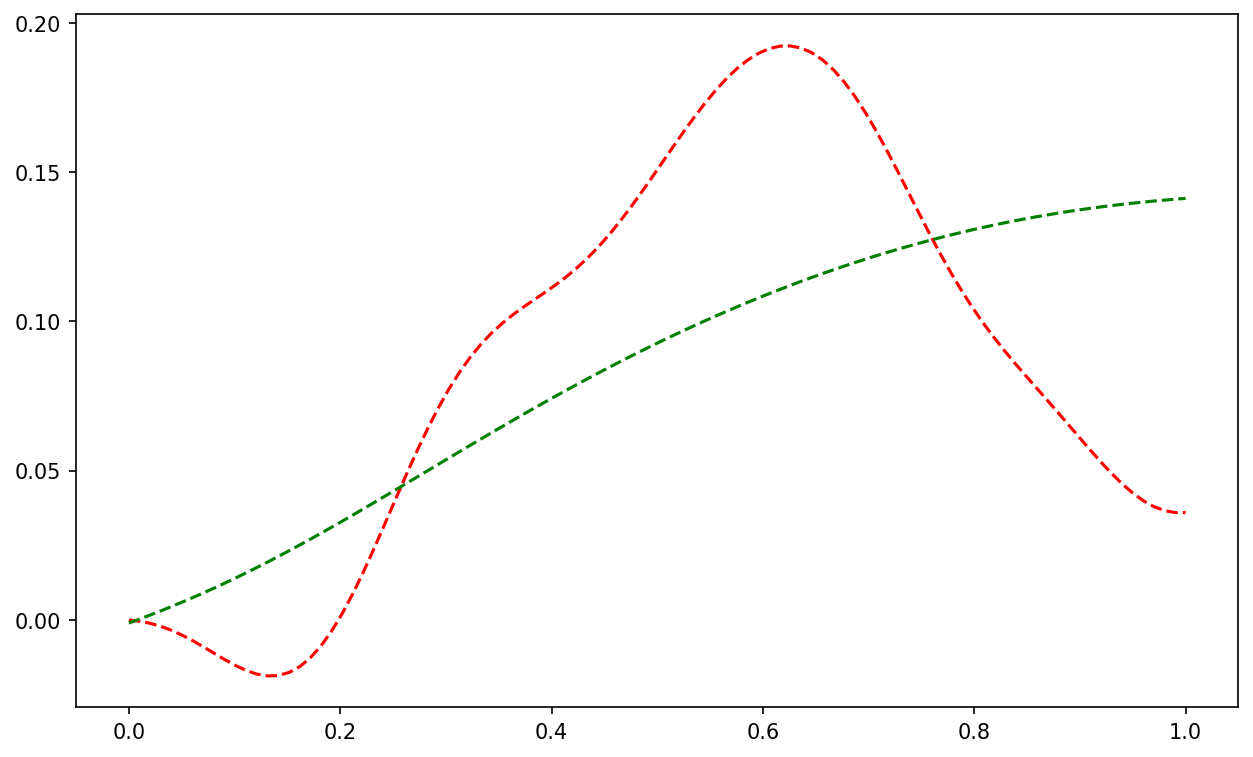

In [26]:
plt.figure(figsize=(10, 6), dpi=150)
# plt.plot(x, u, '-', color='darkblue', label="GRF")
plt.plot(y, Guy, 'r--', label="Integral")
plt.plot(y, Guy_pred, 'g--', label="Predicted Integral")
plt.show()